## Installation and Requirements

In [1]:
# !pip install qc-grid
# !pip install qc-atomdb

In [2]:
# Import required libraries
import numpy as np
from functools import lru_cache

from grid.onedgrid import Trapezoidal
from grid.rtransform import LinearFiniteRTransform
from grid.utils import convert_cart_to_sph, generate_real_spherical_harmonics
from grid.becke import BeckeWeights
from grid import AtomGrid
from atomdb import make_promolecule

import matplotlib.pyplot as plt

In [3]:

# Calculate electron density at grid points
def calc_num_e(promol, points):
    return promol.density(points)


In [4]:
# Global list to save the calculated points, weights, and differences
global_xc_list = []
global_wc_list = []
global_diff_list = []


def adaptive_recursive_fn(xi, xf, promol,
                        thresh=1,
                        variable='num_electrons',
                        onedgrid_fn=Trapezoidal,
                        radialgrid_fn=LinearFiniteRTransform):

    print(f"\nCalculating adaptive grid for [{xi}, {xf}]")
    print("promol:", promol)

    match variable:
        case "num_electrons":
            calc_variable = calc_num_e
            tol = 1e-15


    atnum = promol.atoms[0]._data.atnum
    atcoord = promol.coords[0]


    # 2-point grid
    onedgrid_2 = onedgrid_fn(npoints = 2)
    radial_grid_2 = radialgrid_fn(xi, xf).transform_1d_grid(onedgrid_2)
    angular_grid_2 = AtomGrid.from_preset(
        atnum=atnum,
        preset='ultrafine',
        rgrid=radial_grid_2,
        center=atcoord
    )
    dens_test_2 = promol.density(angular_grid_2.points)
    val_ref_integrand_2 = calc_variable(promol, angular_grid_2.points)
    val_ref_2 = np.nansum(val_ref_integrand_2 * angular_grid_2.weights)
    print(f"\n2 Points Angular Value: {val_ref_2}")


    # 3-point grid
    onedgrid_3 = onedgrid_fn(npoints = 3)
    radial_grid_3 = radialgrid_fn(xi, xf).transform_1d_grid(onedgrid_3)
    angular_grid_3 = AtomGrid.from_preset(
        atnum=atnum,
        preset='ultrafine',
        rgrid=radial_grid_3,
        center=atcoord
    )
    dens_test_3 = promol.density(angular_grid_2.points)
    val_ref_integrand_3 = calc_variable(promol, angular_grid_3.points)
    val_ref_3 = np.nansum(val_ref_integrand_3 * angular_grid_3.weights)
    print(f"3 Points Angular Value: {val_ref_3}")

    # N-point grid only to see the more accurate results, not used in the algorithm. Here, N = 100
    onedgrid_N = onedgrid_fn(npoints = 100)
    radial_grid_N = radialgrid_fn(xi, xf).transform_1d_grid(onedgrid_N)
    angular_grid_N = AtomGrid.from_preset(
        atnum=atnum,
        preset='ultrafine',
        rgrid=radial_grid_N,
        center=atcoord
    )
    dens_test_N = promol.density(angular_grid_N.points)
    val_ref_integrand_N = calc_variable(promol, angular_grid_N.points)
    val_ref_N = np.nansum(val_ref_integrand_N * angular_grid_N.weights)
    print(f"N Points Angular Value: {val_ref_N}")

    # Obtain the center point and weight to further range subdivision. Index [1] used because it's the midpoint from [0,1,2] in 3-points grid
    xc = radial_grid_3.points[1]
    wc = radial_grid_3.weights[1]

    # Calculate the difference
    diff = abs(val_ref_2 - val_ref_3)

    # Save and print the value
    global_xc_list.append(xc)
    global_wc_list.append(wc)
    global_diff_list.append(diff)
    print(f"xc: {xc}, wc: {wc}")
    print(f"diff: {diff}")
    # print(global_xc_list)
    # print(global_wc_list)

    if diff < thresh:
        return diff
    else:
        # Continue recursively
        return {
            "left": adaptive_recursive_fn(xi, xc, promol, thresh, variable, onedgrid_fn, radialgrid_fn),
            "right": adaptive_recursive_fn(xc, xf, promol, thresh, variable, onedgrid_fn, radialgrid_fn)
        }

In [5]:
x_i = 0
x_f = 10

atcoords = np.array([[0, 0, 0]])
atnums = np.array([10])  # Atomic number 10 is neon
promol = make_promolecule(atnums=atnums, coords=atcoords, dataset='slater')


# Add initial point x_i and x_f to the global list
radial_grid_0 = LinearFiniteRTransform(x_i, x_f).transform_1d_grid(Trapezoidal(npoints=2))
global_xc_list.extend(radial_grid_0.points[:2])
global_wc_list.extend(radial_grid_0.weights[:2])

# Run the main adaptive recursive radial function
diff_log = adaptive_recursive_fn(0, 10, promol=promol, thresh=0.0001)


Calculating adaptive grid for [0, 10]
promol: <atomdb.promolecule.Promolecule object at 0x7f382771faa0>

2 Points Angular Value: 2.7195041513369354e-08
3 Points Angular Value: 0.0038419706451591463
N Points Angular Value: 9.901472339141483
xc: 5.0, wc: 5.0
diff: 0.003841943450117633

Calculating adaptive grid for [0, 5.0]
promol: <atomdb.promolecule.Promolecule object at 0x7f382771faa0>

2 Points Angular Value: 0.0019209785238191949


/home/azhar04/anaconda3/envs/grid-env/lib/python3.12/site-packages/grid/atomgrid.py:895: UserWarning: Lebedev weights are negative which can introduce round-off errors.
  sphere_grid = AngularGrid(degree=deg_i, method=method)


3 Points Angular Value: 0.6311406282125602
N Points Angular Value: 9.991894679178257
xc: 2.5, wc: 2.5
diff: 0.629219649688741

Calculating adaptive grid for [0, 2.5]
promol: <atomdb.promolecule.Promolecule object at 0x7f382771faa0>

2 Points Angular Value: 0.31509006947532536
3 Points Angular Value: 4.862602439403497
N Points Angular Value: 9.889138170107728
xc: 1.25, wc: 1.25
diff: 4.547512369928171

Calculating adaptive grid for [0, 1.25]
promol: <atomdb.promolecule.Promolecule object at 0x7f382771faa0>

2 Points Angular Value: 2.3525287023329167
3 Points Angular Value: 6.146622876472291
N Points Angular Value: 8.210898541668227
xc: 0.625, wc: 0.625
diff: 3.7940941741393743

Calculating adaptive grid for [0, 0.625]
promol: <atomdb.promolecule.Promolecule object at 0x7f382771faa0>

2 Points Angular Value: 2.4851792626529168
3 Points Angular Value: 2.8543973531857123
N Points Angular Value: 4.328208502446685
xc: 0.3125, wc: 0.3125
diff: 0.36921809053279553

Calculating adaptive grid fo

radial grid: (1000,)


/home/azhar04/anaconda3/envs/grid-env/lib/python3.12/site-packages/grid/atomgrid.py:895: UserWarning: Lebedev weights are negative which can introduce round-off errors.
  sphere_grid = AngularGrid(degree=deg_i, method=method)


0.0
0.008346647529045436
0.026811658853030777
0.04847936636546242
0.06931252432657932
0.08716990991597623
0.10112536413318642
0.11100210521764381
0.11705921035378362
0.11978460612549682
0.11976184940446319
0.11758744774660809
0.11382232269275248
0.10896594174059727
0.10344515615032562
0.09761227182741071
0.09174863631613903
0.08607125559056307
0.08074081109978168
0.07587003918181878
0.0715318394200063
0.06776675137299042
0.06458961997731304
0.06199538688777362
0.059964018017744224
0.058464620567659595
0.05745882580780161
0.05690352365115177
0.05675303642234213
0.05696081550076486
0.057480737855694075
0.05826807147313983
0.059280170174132285
0.06047695000890118
0.061821191607751895
0.0632787057871678
0.06481839340260562
0.06641222495028619
0.06803516069669344
0.06966502808860346
0.07128236982694959
0.07287027316634231
0.0744141886812205
0.07590174483317301
0.07732256312510646
0.07866807738292733
0.07993135970400445
0.08110695482594552
0.08219072404435564
0.08317969933212971
0.0840719479

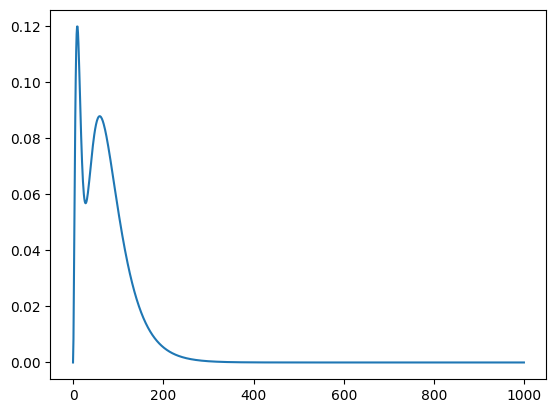

In [10]:
xi = 0
xf = 11

atcoords = np.array([[0, 0, 0]])
atnums = np.array([10])  # Atomic number 10 is neon
promol = make_promolecule(atnums=atnums, coords=atcoords, dataset='slater')

atnum = promol.atoms[0]._data.atnum
atcoord = promol.coords[0]


onedgrid = Trapezoidal(npoints = 1000)
radial_grid = LinearFiniteRTransform(xi, xf).transform_1d_grid(onedgrid)
print("radial grid:", radial_grid.points.shape)
angular_grid = AtomGrid.from_preset(
    atnum=atnum,
    preset='fine',
    rgrid=radial_grid,
    center=atcoord
)

density_list = []
idx = angular_grid._indices
for i in range(len(idx)-1):
    dens = calc_num_e(promol, angular_grid.points[idx[i]:idx[i+1]])
    weights = angular_grid.weights[idx[i]:idx[i+1]]
    val = np.nansum(dens * weights)
    density_list.append(val)
    print(val)

print(density_list)
print(sum(density_list))

dens_full = calc_num_e(promol, angular_grid.points)
print(np.nansum(dens_full * angular_grid.weights))

plt.plot(density_list)

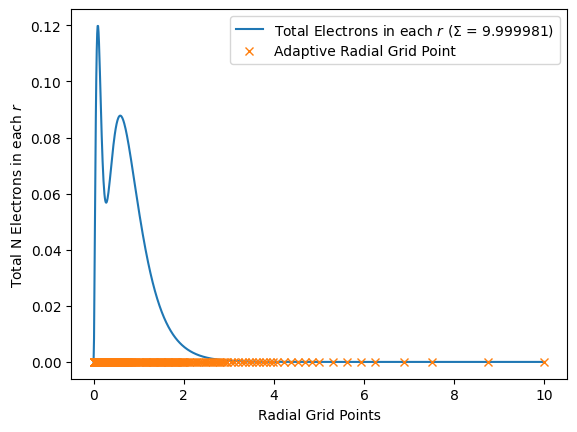

In [23]:
sum_e = np.sum(density_list)
x_values = np.linspace(0, 10, 1000)
plt.plot(x_values, density_list, label=f'Total Electrons in each $r$ (Σ = {sum_e:.6f})')
plt.plot(global_xc_list, np.repeat(0, len(global_xc_list)), 'x', markersize=6, label='Adaptive Radial Grid Point')
plt.ylabel(f"Total N Electrons in each $r$")
plt.xlabel("Radial Grid Points")
plt.legend()

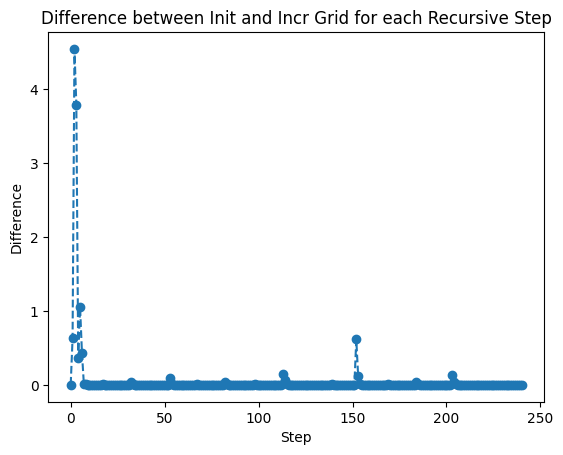

In [15]:
plt.title("Difference between Init and Incr Grid for each Recursive Step")
plt.xlabel("Step")
plt.ylabel("Difference")
plt.plot(global_diff_list, marker='o', linestyle='--', label='Difference value')